<a href="https://colab.research.google.com/github/AndresWV/AndresWV.github.io/blob/main/ProyectoWisdm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Librerias usadas**

In [78]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import keras
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization

## **1) Obtain**


1.1 Abrir el archivo




In [2]:
wisdmHarFile = open('WISDM_ar_v1.1_raw.txt')

1.2 df con los datos



In [3]:

#wisdmHarDf = pd.DataFrame(data = wisdmHarFile) 
#wisdmHarDf.head()

## **Entrega 02 - SCRUB**



Eliminar filas con datos faltantes


Tomar lineas

In [4]:
readLiness = wisdmHarFile.readlines()

Crear Df con los datos limpios, indicando las lineas con datos faltantes(print en el mismo formato solicitado)

In [5]:
wisdmHarDf = []

for nLine,line in enumerate(readLiness):
    try:
        #Separar los datos para extraer valores de las col
        line = line.split(',')
        #Quitar punto y coma del final
        lineStrip = line[5].split(';')[0]
        #Quitar saltos espacios de inicio y fin
        lineStrip = lineStrip.strip()
        #Si queda vacio salta a la excepción para que no se agregue al df
        if lineStrip == '':
            break;
        col = [line[0], line[1], line[2], line[3], line[4], lineStrip]
        #agregar col limpia
        wisdmHarDf.append(col)
    except:
        print('Error at line number: ', nLine)

Error at line number:  281873
Error at line number:  281874
Error at line number:  281875


Agregar al DataFrame los nombres de las columnas

In [6]:
columns = ['user', 'activity', 'time', 'x', 'y', 'z']
wisdmHarDf2 = pd.DataFrame(data = wisdmHarDf, columns = columns)



Visualizar las 5 primeras filas del DataFrame (.head())


In [7]:
wisdmHarDf2.head()

,user,activity,time,x,y,z
0,33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.1849703,12.108489,7.205164


Buscar datos nulos y eliminarlos si es que existen

In [8]:
#Contar los datos vacios, si existen, dropeo de nuevo
nVacios = wisdmHarDf2.isnull().sum().sum()
if nVacios>0:
  wisdmHarDf2 = wisdmHarDf2.dropna()
else:
  print("No hay datos nulos!") 


No hay datos nulos!


Visualizar los tipo de datos a los que pertenece cada columna (.info())

In [9]:
wisdmHarDf2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343416 entries, 0 to 343415
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user      343416 non-null  object
 1   activity  343416 non-null  object
 2   time      343416 non-null  object
 3   x         343416 non-null  object
 4   y         343416 non-null  object
 5   z         343416 non-null  object
dtypes: object(6)
memory usage: 15.7+ MB


Cambiar el tipo de datos de las variables predictoras a valores reales, para realizar la clasificación

In [10]:
wisdmHarDf2 = wisdmHarDf2.astype({'x':'float','y':'float','z':'float'})

Imprimir los tipos de datos de las variables del DataFrame

In [11]:
wisdmHarDf2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343416 entries, 0 to 343415
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user      343416 non-null  object 
 1   activity  343416 non-null  object 
 2   time      343416 non-null  object 
 3   x         343416 non-null  float64
 4   y         343416 non-null  float64
 5   z         343416 non-null  float64
dtypes: float64(3), object(3)
memory usage: 15.7+ MB


Eliminar las columnas que no se utilizaran para la clasificación

In [12]:
#Generar un nuevo df sin user ni time
wisdmHarDf3 = wisdmHarDf2.drop(['user', 'time'], axis=1)
#Ver que se hayan eliminado correctamente las col que nos se usaran
wisdmHarDf3.head()

,activity,x,y,z
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164


Utilizar el comando value_counts para obtener un detalle de cuantas instancias se tienen por actividad. El objetivo consiste en identificar la presencia del balance o desbalance en las categorías a modelar

In [13]:
wisdmHarDf3.value_counts('activity')

activity
Walking       137375
Jogging       129392
Upstairs       35137
Downstairs     33358
Sitting         4599
Standing        3555
dtype: int64

Este proyecto considera datos con un desbalance de clases. Es necesario balancearlos para que los modelos operen de manera adecuada. Existen muchas maneras de realizar un balance, pero en este proyecto utilizaremos una estrategia sencilla e intuitiva. Simplemente debe identificar la actividad que contenga el número menor de instancias. Se debe realizar un muestreo para las otras actividades utilizando ese valor. De esta manera todas las clases tendrán la misma cantidad de instancias.

In [14]:
#Balancear en torno a Stading que es el menor(3555)
Walking = wisdmHarDf3[wisdmHarDf3['activity']=='Walking'].head(3555).copy()
Jogging = wisdmHarDf3[wisdmHarDf3['activity']=='Jogging'].head(3555).copy()
Upstairs = wisdmHarDf3[wisdmHarDf3['activity']=='Upstairs'].head(3555).copy()
Downstairs = wisdmHarDf3[wisdmHarDf3['activity']=='Downstairs'].head(3555).copy()
Sitting = wisdmHarDf3[wisdmHarDf3['activity']=='Sitting'].head(3555).copy()
Standing = wisdmHarDf3[wisdmHarDf3['activity']=='Standing'].copy()
#nuevo df para el df balanceado 
wisdmHarDf4 = pd.DataFrame()
wisdmHarDf4 = wisdmHarDf4.append([Walking, Jogging, Upstairs, Downstairs, Sitting, Standing])


Establecer el número de instancias y dimensiones del data frame resultante (shape)

In [15]:
wisdmHarDf4.shape

(21330, 4)

Volver a imprimir la cantidad de instancias por categoría para verificar que todo esté en orden. (value_counts)

In [16]:
wisdmHarDf4.value_counts('activity')

activity
Downstairs    3555
Jogging       3555
Sitting       3555
Standing      3555
Upstairs      3555
Walking       3555
dtype: int64

Volver a visualizar las cinco primeras líneas del DataFrame para revisar que todo esté en orden (head)

In [17]:
wisdmHarDf4.head()

,activity,x,y,z
597,Walking,0.844462,8.008764,2.792171
598,Walking,1.116869,8.621680,3.786457
599,Walking,-0.503953,16.657684,1.307553
600,Walking,4.794363,10.760075,-1.184970
601,Walking,-0.040861,9.234595,-0.694638


Separar las variables predictoras (X) de las ctegorias o etiquetas (y)

In [18]:
#Ajuste el codificador de etiquetas(Y) y devuelva las etiquetas codificadas.
wisdmHarDf4['label'] = LabelEncoder().fit_transform(wisdmHarDf4['activity'])
X = wisdmHarDf4[['x', 'y', 'z']]
y = wisdmHarDf4['label']


Estandarizar los datos numericos (StandardScaler)

In [19]:
#Ajuste a los datos codificados para transformarlos. 
X = StandardScaler().fit_transform(X)
scaled_X = pd.DataFrame(data = X, columns = ['x', 'y', 'z'])
scaled_X

,x,y,z
0,0.000503,-0.099190,0.337933
1,0.073590,0.020386,0.633446
2,-0.361275,1.588160,-0.103312
3,1.060258,0.437573,-0.844119
4,-0.237028,0.139962,-0.698386
...,...,...,...
21325,-0.470217,0.178084,0.261019
21326,-0.542658,0.193692,0.248875
21327,-0.628514,0.197593,0.261019
21328,-0.781444,0.049322,0.155768


## **Explore**

Previo al balance se pueden estudiar las actividades para ver cual es la que más realizan las personas y estudiarlas en un futuro, ya que son las que tienen mayor tendencia

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


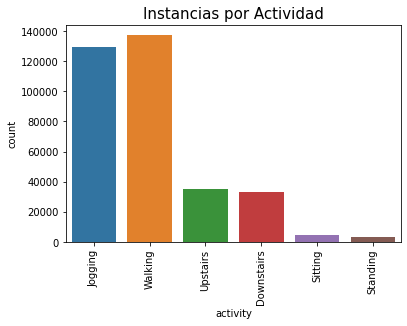

In [20]:
plt.title('Instancias por Actividad', fontsize=15)
sns.countplot(wisdmHarDf2.activity)
plt.xticks(rotation=90)
plt.show()

Diagrama de actividad vs tiempo(Para mirar el balanceo)

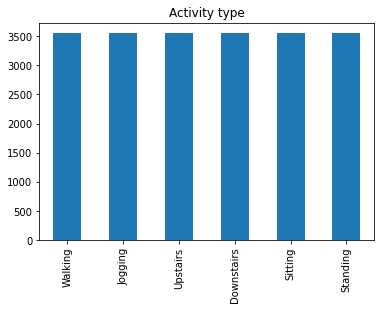

In [21]:
actividadesTiempo = wisdmHarDf4['activity'].value_counts().plot(kind='bar', title='Activity type')


Grafico para mostrar como el nivel de aceleración se va cambiando con el paso del tiempo, con estos graficos podemos concluir cual actividad fisica demanda una mayor resistencia cardiovascular, tan solo evaluando los niveles maximos de aceleración que estas tienen. Haciendo las comparativas con otros graficos, por ejemplo de jogging vs walking, podemos observar que jogging tiene mayores niveles de aceleración y seria normal asumir este resultado, debido a que uno al trotar tiene un ritmo más rapido que al caminar. Se puede aplicar esta misma logica con las demás actividades para tener este tipo de conclusiones.

Text(0, 0.5, 'X acceleration (dg)')

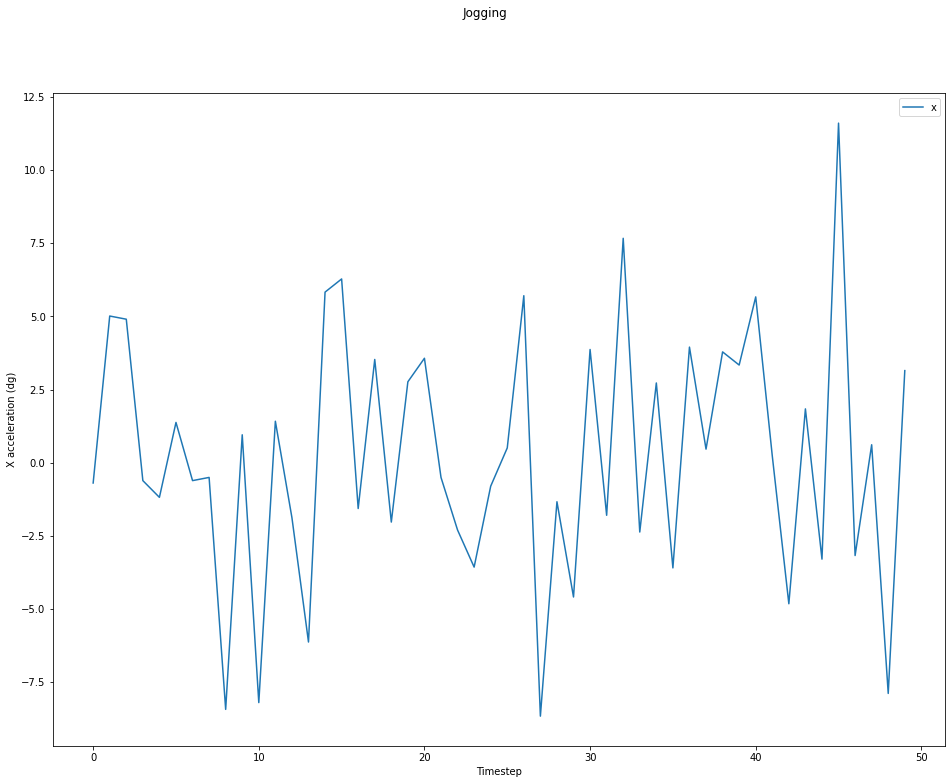

In [22]:
wisdmHarDf4[wisdmHarDf4['activity'] == 'Jogging'][['x']][:50].plot(subplots=True, figsize=(16, 12), title='Jogging')
plt.xlabel('Timestep')
plt.ylabel('X acceleration (dg)')

Text(0, 0.5, 'X acceleration (dg)')

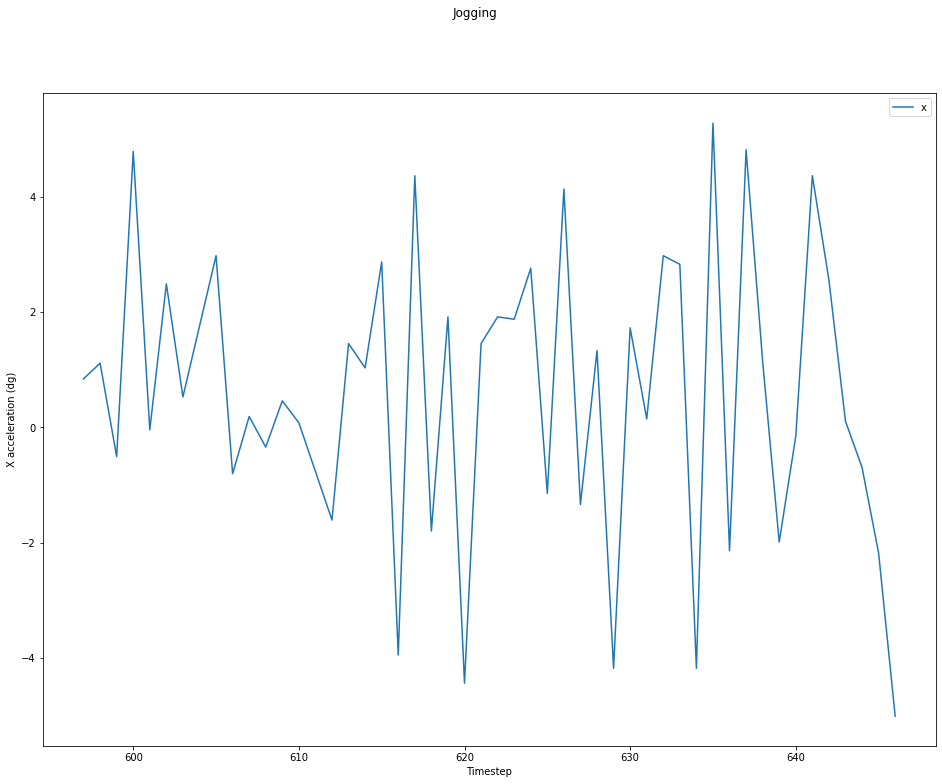

In [23]:
wisdmHarDf4[wisdmHarDf4['activity'] == 'Walking'][['x']][:50].plot(subplots=True, figsize=(16, 12), title='Jogging')
plt.xlabel('Timestep')
plt.ylabel('X acceleration (dg)')

Estudio en del acelerometro base a los ejes, con esto podemos estudiar los ejes que más impactan en el acelerometro segun la actividad a realizar

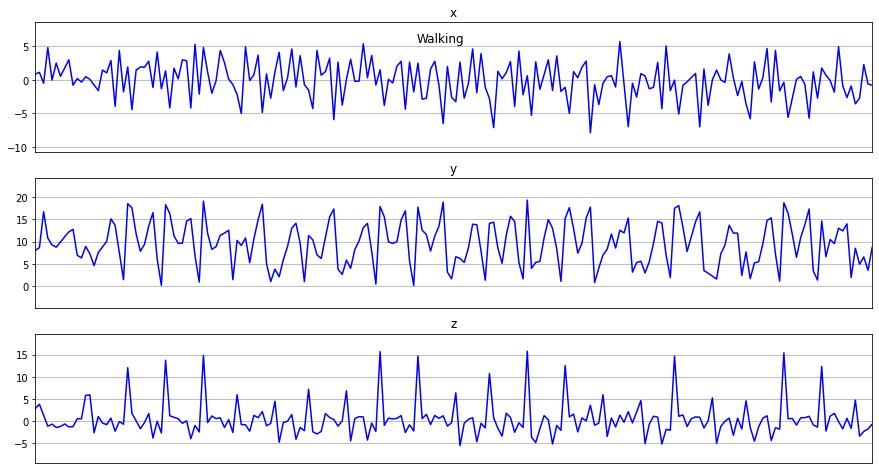

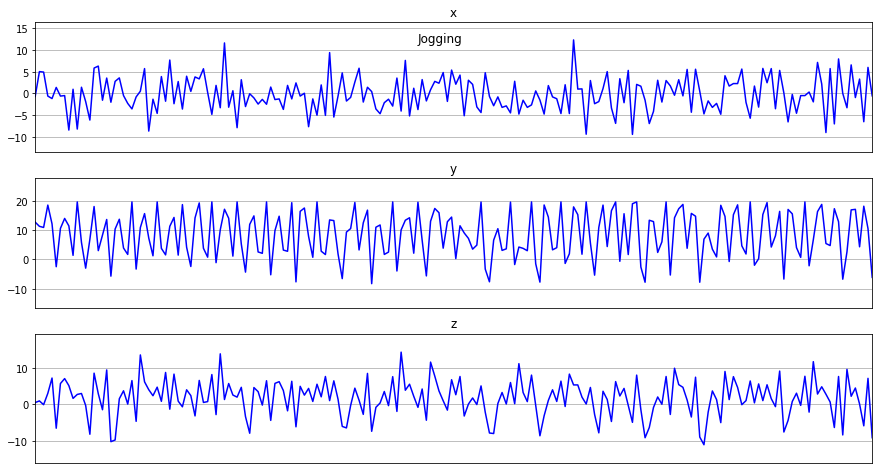

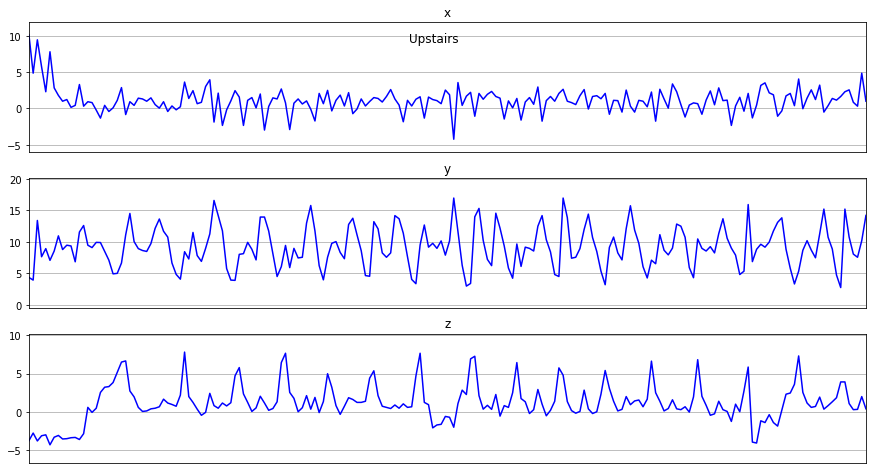

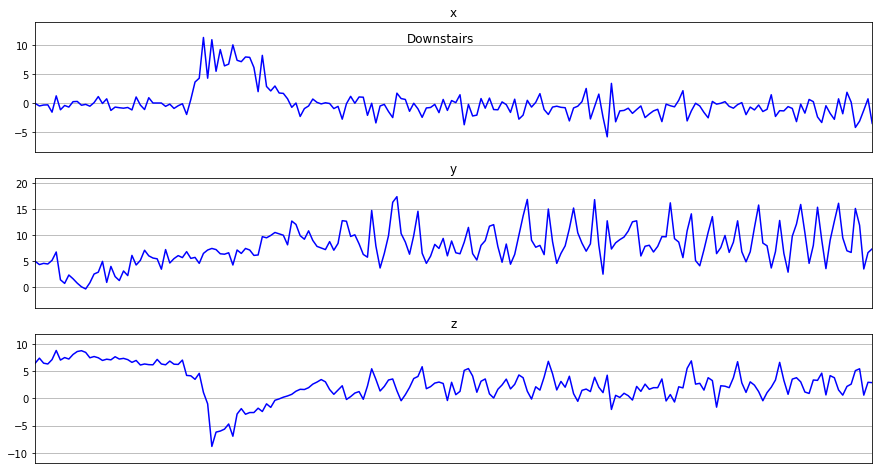

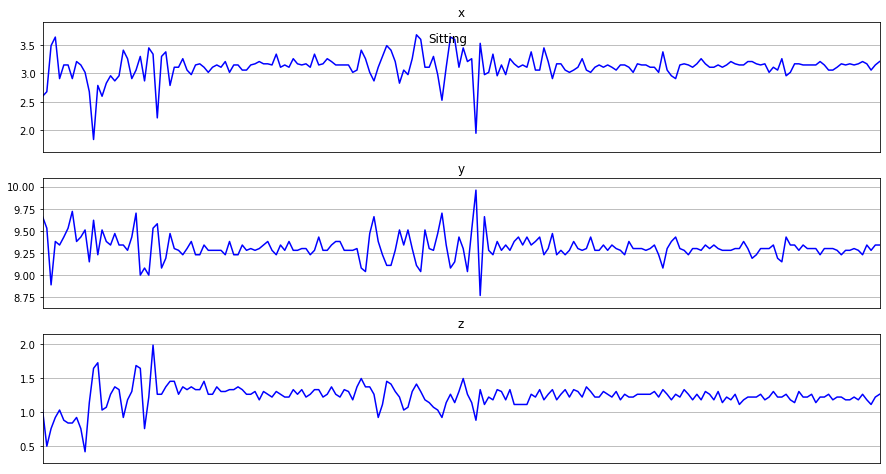

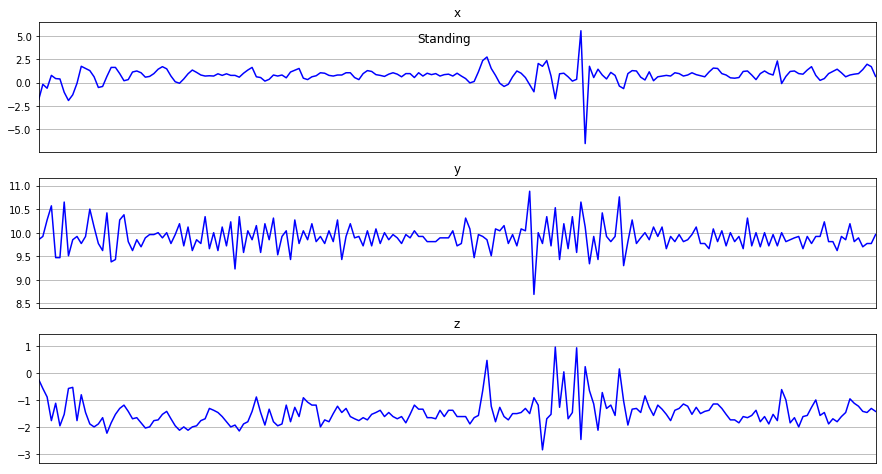

In [24]:
def plot_activity(activity, wisdmHarDf2):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    #ejes
    plot_axis(ax0, wisdmHarDf2['time'], wisdmHarDf2['x'], 'x')
    plot_axis(ax1, wisdmHarDf2['time'], wisdmHarDf2['y'], 'y')
    plot_axis(ax2, wisdmHarDf2['time'], wisdmHarDf2['z'], 'z')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    #Escala
    plt.subplots_adjust(top=1.0)
    plt.show()

def plot_axis(ax, x, y, activity):
    ax.plot(x, y, 'b')
    ax.set_title(activity)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

activities = wisdmHarDf2['activity'].value_counts().index
for activity in activities:
    data_for_plot = wisdmHarDf2[(wisdmHarDf2['activity'] == activity)][:20*10]
    plot_activity(activity, data_for_plot)

# Etapa 4 MODEL

**2D CNN Model**

In [69]:

N_FEATURES = 3
X = []
y1 = []
for i in range(0, len(wisdmHarDf4) - 80, 40):
  x = wisdmHarDf4['x'].values[i: i + 80]
  y = wisdmHarDf4['y'].values[i: i + 80]
  z = wisdmHarDf4['z'].values[i: i + 80]
  label = stats.mode(wisdmHarDf4['label'][i: i + 80])[0][0]
  X.append([x, y, z])
  y1.append(label)

# Bring the segments into a better shape
X = np.asarray(X1).reshape(-1, 80, N_FEATURES)
y = np.asarray(y1)


**Split entre test y entrenamiento**

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)
#Hiperparametro
print(X_train.shape," ",X_test.shape)
print(X_train[0].shape," " ,X_test[0].shape)


(425, 80, 3)   (107, 80, 3)
(80, 3)   (80, 3)


In [73]:
X_train = X_train.reshape(425, 80, 3, 1)
X_test = X_test.reshape(107, 80, 3, 1)

**Modelo de entrenamiento**

In [80]:
model = Sequential()
model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
model.add(Dropout(0.1))
model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(X_train, y_train, epochs = 10, validation_data= (X_test, y_test), verbose=1)

Epoch 1/10
14/14 [==============================] - 1s 22ms/step - loss: 2.1228 - accuracy: 0.2588 - val_loss: 1.4457 - val_accuracy: 0.4766
Epoch 2/10
14/14 [==============================] - 0s 8ms/step - loss: 1.4175 - accuracy: 0.4306 - val_loss: 1.1372 - val_accuracy: 0.6822
Epoch 3/10
14/14 [==============================] - 0s 9ms/step - loss: 1.1514 - accuracy: 0.5271 - val_loss: 0.8577 - val_accuracy: 0.8131
Epoch 4/10
14/14 [==============================] - 0s 8ms/step - loss: 0.9760 - accuracy: 0.5953 - val_loss: 0.6536 - val_accuracy: 0.8505
Epoch 5/10
14/14 [==============================] - 0s 10ms/step - loss: 0.7987 - accuracy: 0.6871 - val_loss: 0.4987 - val_accuracy: 0.8598
Epoch 6/10
14/14 [==============================] - 0s 9ms/step - loss: 0.6447 - accuracy: 0.7529 - val_loss: 0.3795 - val_accuracy: 0.8785
Epoch 7/10
14/14 [==============================] - 0s 10ms/step - loss: 0.6420 - accuracy: 0.7459 - val_loss: 0.3892 - val_accuracy: 0.9065
Epoch 8/10
14/14 

# Etapa 5 Interpret

**Resultados**

In [82]:
print(model.evaluate(X_test, y_test))

4/4 [==============================] - 0s 3ms/step - loss: 0.2604 - accuracy: 0.8972
[0.26044899225234985, 0.8971962332725525]


**Gráfico de precisión y pérdida durante el entrenamiento**

In [84]:
#obtener diccionario con todo lo sucedido durante el entrenamiento
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

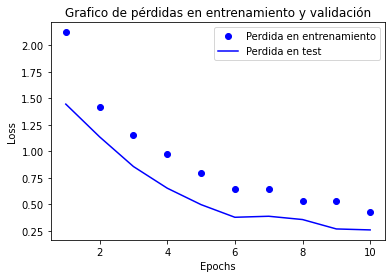

In [87]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)
#Grafica
plt.plot(epochs, loss, 'bo', label='Perdida en entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Perdida en test')
plt.title('Grafico de pérdidas en entrenamiento y validación')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

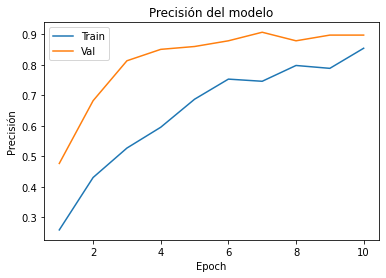

In [90]:
plt.plot(epochs, history.history['accuracy'])
plt.plot(epochs, history.history['val_accuracy'])
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
